In [55]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [56]:
import requests
from bs4 import BeautifulSoup
import bs4
from fastnumbers import isfloat 
from fastnumbers import fast_float
from multiprocessing.dummy import Pool as ThreadPool 

In [57]:
def ffloat(string):
    if string is None:
        return np.nan
    if type(string)==float or type(string)==np.float64:
        return string
    if type(string)==int or type(string)==np.int64:
        return string
    return fast_float(string.split(" ")[0].replace(',','').replace('%',''),
                      default=np.nan)

def ffloat_list(string_list):
    return list(map(ffloat,string_list))

def remove_multiple_spaces(string):
    if type(string)==str:
        return ' '.join(string.split())
    return string

def get_children(html_content):
    return [item for item in html_content.children if 
            type(item)==bs4.element.Tag or 
            len(str(item).replace("\n","").strip())>0]

In [58]:
response = requests.get("https://finance.yahoo.com/gainers", timeout=240)
response.status_code

200

In [59]:
def get_table_simple(table,is_table_tag=True):
    elems = table.find_all('tr') if is_table_tag else get_children(table)
    table_data = list()
    for row in elems:
        row_data = list()
        row_elems = get_children(row)
        for elem in row_elems:
            text = elem.text.strip().replace("\n","")
            text = remove_multiple_spaces(text)
            if len(text)==0:
                continue
            row_data.append(text)
        table_data.append(row_data)
    return table_data

In [60]:
html = BeautifulSoup(response.content, "html.parser")

In [61]:
init_list = get_table_simple(html)
top5list = []
for x in range(6):
    top5list.append(init_list[x])
dftop5gainers = pd.DataFrame.from_records(top5list)
dftop5gainers

,0,1,2,3,4,5,6,7,8,9
0,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
1,ZS,"Zscaler, Inc.",98.09,+22.29,+29.41%,22.809M,3.037M,12.688B,N/A,None
2,PTKFF,PT Kalbe Farma Tbk.,0.1020,+0.0220,+27.50%,5.158M,"304,519",5.58B,N/A,None
3,TBVPF,Thai Beverage Public Company Limited,0.5500,+0.1150,+26.44%,"25,909","102,600",14.231B,25.00,None
4,PTXKY,PT XL Axiata Tbk,3.8000,+0.7200,+23.38%,"47,587","7,756",2.266B,N/A,None
5,NWAU,"Consumer Automotive Finance, Inc.",0.0225,+0.0028,+14.21%,"549,897","523,927",39.381B,N/A,None


In [2]:
df6012 = web.DataReader('6012.KL', data_source='yahoo', start='2011-03-12',end='2020-03-12')

In [3]:
df6012['Difference'] = df6012['Open'] - df6012['Close']
df6012.head()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2011-03-14,5.41,5.35,5.40,5.39,3479700.0,3.575402,0.01
2011-03-15,5.39,5.36,5.38,5.37,4481900.0,3.562135,0.01
2011-03-16,5.38,5.34,5.36,5.36,4017800.0,3.555503,0.00
2011-03-17,5.36,5.33,5.35,5.35,3148300.0,3.548868,0.00
2011-03-18,5.40,5.34,5.35,5.40,3830400.0,3.582035,-0.05


In [4]:
df6012.tail()

,High,Low,Open,Close,Volume,Adj Close,Difference
Date,,,,,,,
2020-03-06,5.45,5.36,5.37,5.43,1813100.0,5.43,-0.06
2020-03-09,5.46,5.30,5.38,5.31,3013200.0,5.31,0.07
2020-03-10,5.37,5.25,5.29,5.25,3148600.0,5.25,0.04
2020-03-11,5.31,5.21,5.27,5.27,3875400.0,5.27,0.00
2020-03-12,5.31,5.20,5.25,5.25,2038200.0,5.25,0.00


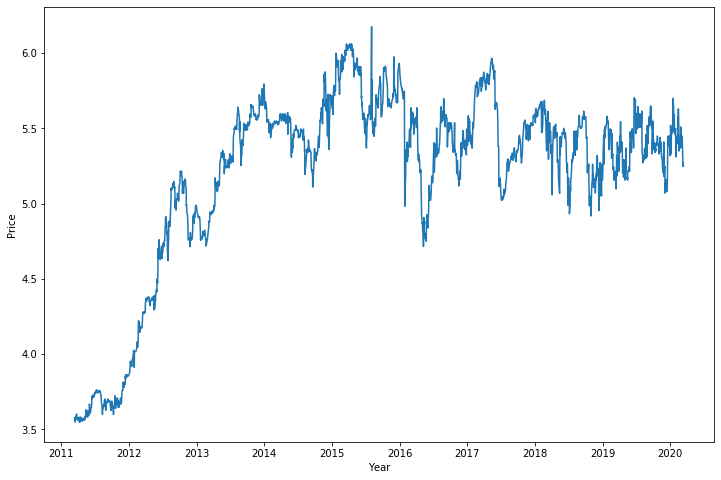

In [5]:
plt.figure(figsize = (12,8))
plt.plot(df6012['Adj Close'])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [6]:
df6012.to_csv('maxis.csv')

In [7]:
dfPre = []
dfPre = df6012[['Adj Close']]

In [8]:
print(dfPre.head())

            Adj Close
Date                 
2011-03-14   3.575402
2011-03-15   3.562135
2011-03-16   3.555503
2011-03-17   3.548868
2011-03-18   3.582035


In [9]:
forecast_out = 30 #predict n days into the future, in this case, 30
dfPre['Prediction'] = dfPre[['Adj Close']].shift(-forecast_out)
print(dfPre.head())

            Adj Close  Prediction
Date                             
2011-03-14   3.575402    3.555503
2011-03-15   3.562135    3.562135
2011-03-16   3.555503    3.568769
2011-03-17   3.548868    3.562135
2011-03-18   3.582035    3.562135


C:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
X = np.array(dfPre.drop(['Prediction'], 1))
len(X)

2225

In [11]:
#reserving 60 data for testing
X_new = X[0:2165]
len(X_new) + 60

2225

In [12]:
X_new[0:10]

array([[3.57540226],
       [3.56213546],
       [3.55550337],
       [3.54886842],
       [3.5820353 ],
       [3.56876922],
       [3.56876922],
       [3.56876922],
       [3.60193563],
       [3.5820353 ]])

In [13]:
y = np.array(dfPre['Prediction'])
y_new = y[:-60]
len(y_new)

2165

In [14]:
y_new[0:10]

array([3.55550337, 3.56213546, 3.56876922, 3.56213546, 3.56213546,
       3.57540226, 3.56876922, 3.56876922, 3.56213546, 3.56876922])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2)

In [16]:
y = np.array(dfPre['Prediction'])
y = y[:-forecast_out]
print(y)
len(y)

[3.55550337 3.56213546 3.56876922 ... 5.25       5.26999998 5.25      ]


2195

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
y_pre = lr.predict(X[2195:2225])
print("Predicted last 30 days")
print(y_pre)

Predicted last 30 days
[5.32440639 5.36835577 5.43867444 5.43867444 5.40351511 5.44746407
 5.41230473 5.40351511 5.56173212 5.49141345 5.6056815  5.47383378
 5.35956572 5.37714539 5.40351511 5.43867444 5.39472506 5.44746407
 5.37714539 5.50020349 5.4298844  5.44746407 5.38593544 5.44746407
 5.38593544 5.4298844  5.32440639 5.27166738 5.28924705 5.27166738]


In [19]:
confidence = lr.score(X_test, y_test)
print("Confidence Score: ", confidence)

Confidence Score:  0.8435601479998545


In [20]:
x_forecast = np.array(dfPre.drop(['Prediction'], 1))[-forecast_out:]
print("Actual last 30 days: ")
print(x_forecast)

Actual last 30 days: 
[[5.30999994]
 [5.36000013]
 [5.44000006]
 [5.44000006]
 [5.4000001 ]
 [5.44999981]
 [5.40999985]
 [5.4000001 ]
 [5.57999992]
 [5.5       ]
 [5.63000011]
 [5.48000002]
 [5.3499999 ]
 [5.36999989]
 [5.4000001 ]
 [5.44000006]
 [5.38999987]
 [5.44999981]
 [5.36999989]
 [5.51000023]
 [5.42999983]
 [5.44999981]
 [5.38000011]
 [5.44999981]
 [5.38000011]
 [5.42999983]
 [5.30999994]
 [5.25      ]
 [5.26999998]
 [5.25      ]]


Text(0, 0.5, 'Price')

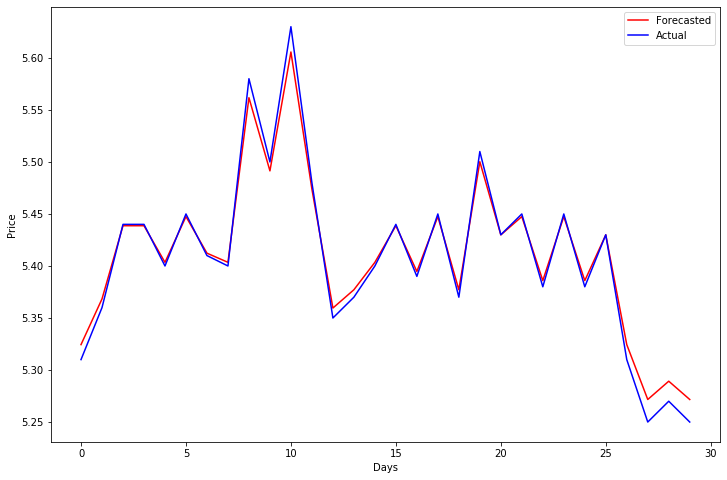

In [21]:
plt.figure(figsize = (12,8))
plt.plot(y_pre, color='r')
plt.plot(x_forecast, color='b')
plt.legend(['Forecasted', 'Actual'])
plt.xlabel("Days")
plt.ylabel("Price")

In [22]:
print("Mean Squared Error: ", metrics.mean_squared_error(y_pre, x_forecast))

Mean Squared Error:  0.00010956483712283828


In [23]:
y_pre2 = [] 
y_pre2.append(np.array(y_pre))
for x in range(11):
    y_pre_alt = y_pre2[x]
    y_pre_in = lr.predict(y_pre_alt.reshape(-1, 1))
    y_pre2.append(np.array(y_pre_in))

In [24]:
forward = []
for x in y_pre2:
    for y in x:
        forward.append(y)

print(y_pre2)
print(forward)

[array([5.32440639, 5.36835577, 5.43867444, 5.43867444, 5.40351511,
       5.44746407, 5.41230473, 5.40351511, 5.56173212, 5.49141345,
       5.6056815 , 5.47383378, 5.35956572, 5.37714539, 5.40351511,
       5.43867444, 5.39472506, 5.44746407, 5.37714539, 5.50020349,
       5.4298844 , 5.44746407, 5.38593544, 5.44746407, 5.38593544,
       5.4298844 , 5.32440639, 5.27166738, 5.28924705, 5.27166738]), array([5.33706943, 5.37570024, 5.43750925, 5.43750925, 5.40660474,
       5.44523519, 5.41433069, 5.40660474, 5.54567501, 5.483866  ,
       5.58430583, 5.46841375, 5.36797393, 5.38342618, 5.40660474,
       5.43750925, 5.39887843, 5.44523519, 5.38342618, 5.49159231,
       5.42978294, 5.44523519, 5.39115249, 5.44523519, 5.39115249,
       5.42978294, 5.33706943, 5.29071267, 5.30616492, 5.29071267]), array([5.34820004, 5.38215591, 5.43648506, 5.43648506, 5.40932049,
       5.44327604, 5.41611147, 5.40932049, 5.53156106, 5.47723192,
       5.56551694, 5.46364963, 5.37536461, 5.3889469 , 5.

Text(0, 0.5, 'Price')

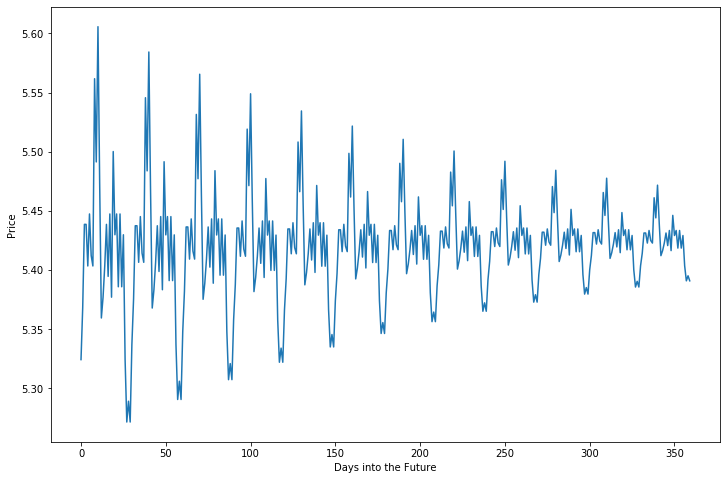

In [25]:
#The stock prices predicted from 1 day into the future, to a year into the future
plt.figure(figsize = (12,8))
plt.plot(forward)
plt.xlabel("Days into the Future")
plt.ylabel("Price")